In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import torch
from tqdm import tqdm

from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score

from pathlib import Path
import os
from datetime import datetime
import uuid
import json
import shutil

from kcm.utils import load_koopman_model, create_discovery_run_dir, save_discovery_params, save_plot, save_artifact, copy_koopman_params_to_discovery

from kcm.koopman_category_model import KoopmanCategoryModel
from kcm.basic_feature_extract import BasicFeatureExtractor
from kcm.discovery import (
    CategoryDiscoveryTrainer,
    train_test_split_indices,
    prep_data_for_discovery,
    check_histograms,
    sup_con_loss,
    BaselineModel,
    HASHHead,
    cluster_acc,
    split_cluster_acc_v1,
    split_cluster_acc_v2,
    create_hash_ids
)
plt.style.use('default')

### Load and Prep Data

In [2]:
######## Koopman Category Model Version ########
KCM_name = "KCM_20250811_225835_b382058c"
################################################

full_path = Path(r"C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments")
koopman_dir = full_path / KCM_name
KCM, KCM_params = load_koopman_model(koopman_dir)
for par in KCM_params:
    print(par)

num_cats: 4
num_samples: 100
num_segments: 8
data_path: C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\data\2-dimensional-systems\dataset_4_class_100_samples.pkl
cats (categories) : ['harmonic_oscillator', 'spring_mass_with_forcing', 'duffing_oscillator', 'van_der_pol_oscillator']
normalize_inputs : True
delay_embeddings: 3
total_observables: 8
svd_rank: 8
dmd_rank: 8
MDS_dimension: 10
cluster_method: kmeans
num_cluseters (k): 5
noisy_data: False
noise_std: 0.01
train_classes: [1, 2, 3]
soft_clustering: True
tau: 1.0


In [3]:
category_params = {'koopman_path' : str(koopman_dir),
                   'drop_na' : True,
                   'normalize_basic_inputs' : False,
                   'input_dim' : KCM.num_clusters,
                   'output_dim' : 6,
                   'hidden_dims' : [200,200], # [200, 200], [1024, 512, 256]
                   'dropout' : 0.3,
                   'classes' : KCM.num_cats,
                   'epochs' : 500,
                   'model_type' : 'SMILE', # baseline, SMILE
                   'temperature' : 0.2}

In [4]:
discovery_run_dir = create_discovery_run_dir()
save_discovery_params(category_params, discovery_run_dir)
copy_koopman_params_to_discovery(koopman_dir, discovery_run_dir)

Created discovery run directory: C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e
Saved discovery parameters to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\discovery_params.json
Copied Koopman params from C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\KCM_20250811_225835_b382058c\params.json → C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\koopman_params.json


In [5]:
# train test split
kcm_X_train, kcm_X_test, kcm_y_train, kcm_y_test, kcm_stacked = prep_data_for_discovery(train=KCM.train_data,
                                                                                        test=KCM.test_data,
                                                                                        normalize_final_data=False, # already normalized within kcm.create_codebook()
                                                                                        pca_reduction=False,
                                                                                        n_components=None,
                                                                                        feat_extractor='kcm')

Extractor = BasicFeatureExtractor(num_cats=KCM.num_cats,
                                  num_samples=KCM.num_samples,
                                  system_dimension=KCM.system_dimension,
                                  data_path=KCM.data_path,
                                  noisy_data=KCM.noisy_data,
                                  noise_std=KCM.noise_std,
                                  seed=KCM.seed)

Extractor.batch_extract_features(normalize_inputs=category_params['normalize_basic_inputs'],
                                 drop_na=category_params['drop_na'])

basic = Extractor.df
basic_train = basic.loc[basic['count'].isin(KCM.train_counts)]
basic_test = basic.loc[basic['count'].isin(KCM.test_counts)]

# train test split
basic_X_train, basic_X_test, basic_y_train, basic_y_test, basic_stacked = prep_data_for_discovery(train=basic_train,
                                                                                                  test=basic_test,
                                                                                                  normalize_final_data=True,
                                                                                                  pca_reduction=True,
                                                                                                  n_components=KCM.num_clusters, # make kcm and basic extract have same feature dimension
                                                                                                  feat_extractor='basic')

Loading data in at C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\data\2-dimensional-systems\dataset_4_class_100_samples.pkl...


Calculating features for all systems: 100%|██████████████████████████████████████████████████████████████████████| 4/4 [00:04<00:00,  1.03s/it]


Dropped columns: []
Final shape: (400, 39)


In [6]:
check_histograms(basic_stacked), print('')
check_histograms(kcm_stacked)

Histograms with duplicate labels:

0/400 (0.0 %) of histograms had duplicate labels,
	affecting 0/400 samples (0.0 %)

Histograms with duplicate labels:

0/400 (0.0 %) of histograms had duplicate labels,
	affecting 0/400 samples (0.0 %)


In [7]:
# Comparing system-target mappings for basic extractor and kcm
mapping = basic[['system_name','target']].drop_duplicates().values
basic_system_dict = {row[1] : row[0] for row in mapping}
kcm_system_dict = {tgt : cat for cat,tgt in zip(KCM.cats,KCM.df['target'].drop_duplicates())}
assert basic_system_dict == kcm_system_dict, 'Dictionaries do not match between extractors'

assert (basic.target.values == KCM.df[['target','sample']].drop_duplicates()['target'].values).all()
assert (basic_train.target.values == KCM.df_train[['target','sample']].drop_duplicates()['target'].values).all()
assert (basic_test.target.values == KCM.df_test[['target','sample']].drop_duplicates()['target'].values).all()

### Category Discovery

In [8]:
kcm_trainer = CategoryDiscoveryTrainer(input_dim=category_params['input_dim'],
                                       output_dim=category_params['output_dim'],
                                       hidden_dims=category_params['hidden_dims'],
                                       dropout=category_params['dropout'],
                                       classes=category_params['classes'],
                                       epochs=category_params['epochs'],
                                       model_type=category_params['model_type'],
                                       temperature=category_params['temperature'])

basic_trainer = CategoryDiscoveryTrainer(input_dim=category_params['input_dim'],
                                         output_dim=category_params['output_dim'],
                                         hidden_dims=category_params['hidden_dims'],
                                         dropout=category_params['dropout'],
                                         classes=category_params['classes'],
                                         epochs=category_params['epochs'],
                                         model_type=category_params['model_type'],
                                         temperature=category_params['temperature'])

In [9]:
kcm_trainer.train_model(kcm_X_train, kcm_X_test, kcm_y_train, kcm_y_test)
save_artifact(kcm_trainer, discovery_run_dir, 'kcm_trainer')

Training SMILE Model: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:40<00:00, 12.31it/s]


Saved trainer object to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\kcm_trainer.pkl


In [10]:
basic_trainer.train_model(basic_X_train, basic_X_test, basic_y_train, basic_y_test)
save_artifact(basic_trainer, discovery_run_dir, 'basic_trainer')

Training SMILE Model: 100%|██████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.51it/s]


Saved trainer object to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\basic_trainer.pkl


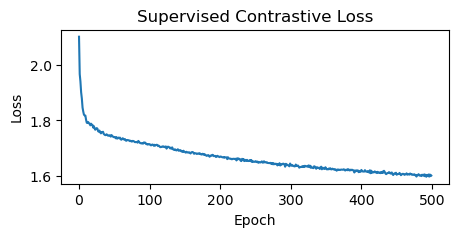

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\koopman_loss.png


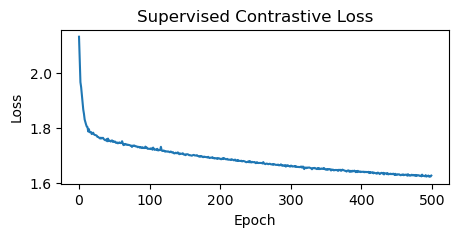

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\basic_loss.png


In [11]:
kcm_trainer.plot_loss(log=True, show=True)
kcm_trainer.plot_loss(log=True, show=False)
save_plot(discovery_run_dir, filename="koopman_loss.png")

basic_trainer.plot_loss(log=True, show=True)
basic_trainer.plot_loss(log=True, show=False)
save_plot(discovery_run_dir, filename="basic_loss.png")

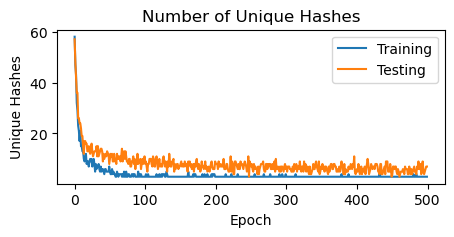

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\koopman_unique_hash_count.png


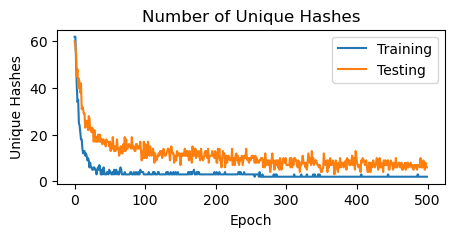

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\basic_unique_hash_count.png


In [12]:
kcm_trainer.plot_unique_hash_count(show=True)
kcm_trainer.plot_unique_hash_count(show=False)
save_plot(discovery_run_dir, filename="koopman_unique_hash_count.png")

basic_trainer.plot_unique_hash_count(show=True)
basic_trainer.plot_unique_hash_count(show=False)
save_plot(discovery_run_dir, filename="basic_unique_hash_count.png")

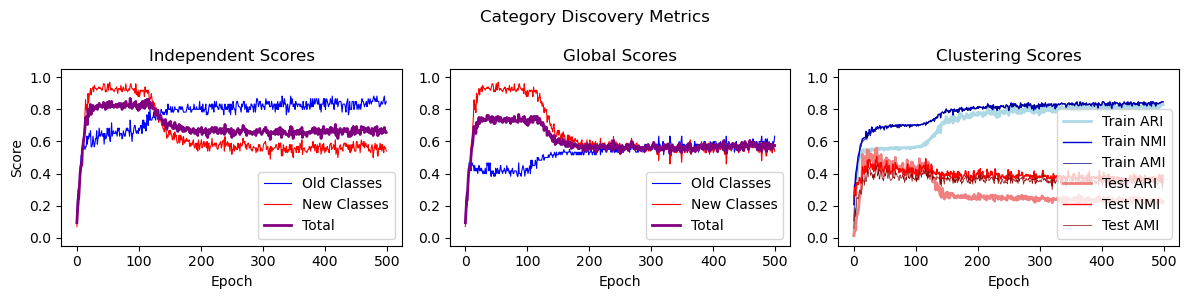

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\koopman_scores.png


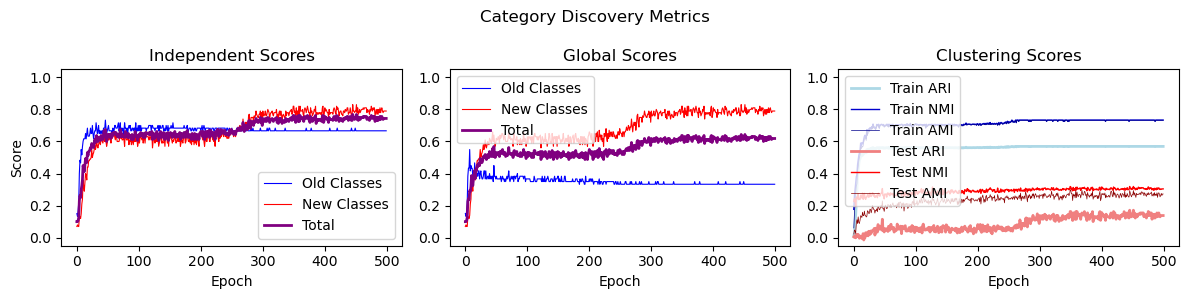

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\basic_scores.png


In [13]:
kcm_trainer.plot_scores(show=True)
kcm_trainer.plot_scores(show=False)
save_plot(discovery_run_dir, filename="koopman_scores.png")

basic_trainer.plot_scores(show=True)
basic_trainer.plot_scores(show=False)
save_plot(discovery_run_dir, filename="basic_scores.png")

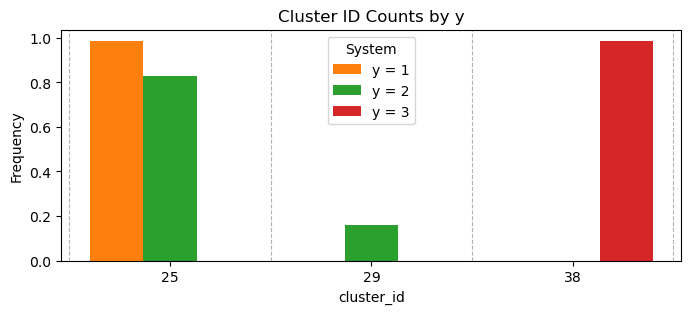

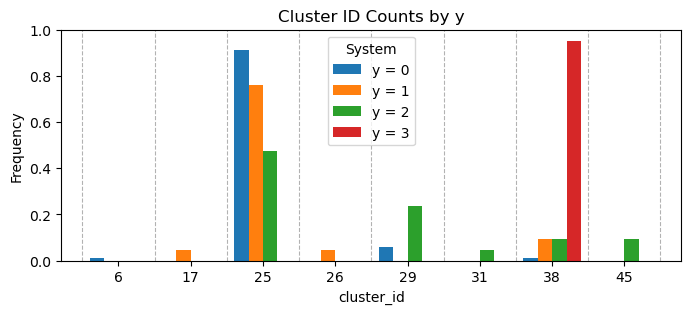

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\koopman_hashes_train_epoch_100.png
Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\koopman_hashes_test_epoch_100.png


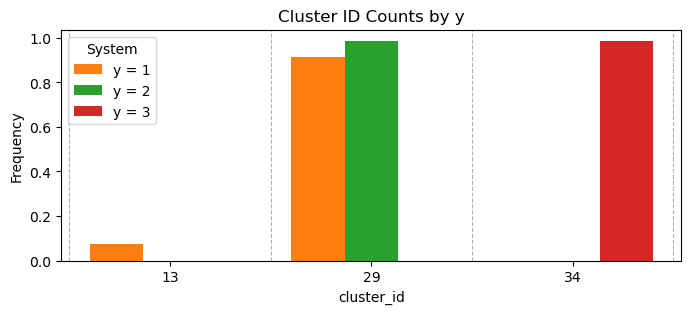

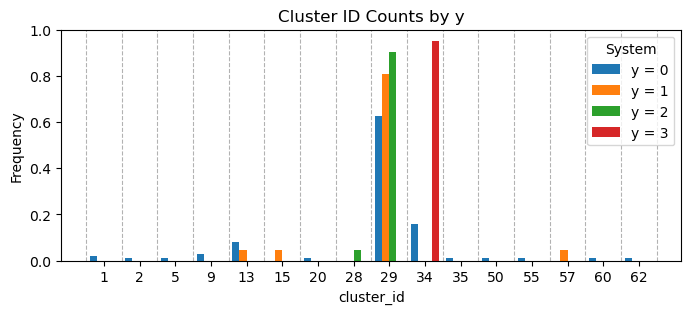

Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\basic_hashes_train_epoch_100.png
Saved plot to C:\Users\peterdb1\Documents\Masters in ACM\(i-j) 625.801-802 - ACM Master's Research\Technical Work\koopman-category-discovery\experiments\discovery_run_20250811_230114_2f470d4e\plots\basic_hashes_test_epoch_100.png


In [15]:
index = 100
kcm_trainer.plot_hashes(index=index,split_testing=False,show=True,save_dir=discovery_run_dir,base_filename="koopman")
kcm_trainer.plot_hashes(index=index,split_testing=False,show=False,save_dir=discovery_run_dir,base_filename="koopman")

basic_trainer.plot_hashes(index=index,split_testing=False,show=True,save_dir=discovery_run_dir,base_filename="basic")
basic_trainer.plot_hashes(index=index,split_testing=False,show=False,save_dir=discovery_run_dir,base_filename="basic")